In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"nmaurya04","key":"4085f669ba7150c517eca6a3a0ada653"}'}

In [ ]:
#create a folder
! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle./kaggle.json

chmod: cannot access '/root/.kaggle./kaggle.json': No such file or directory


In [ ]:
!kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 398, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 90% 73.0M/80.9M [00:00<00:00, 119MB/s] 
100% 80.9M/80.9M [00:00<00:00, 100MB/s]


In [ ]:
#extracting the compressed datset
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


[nltk_data] Downloading package wordnet to /root/nltk_data...


Text Preprocessing complete.
Time Taken: 159 seconds


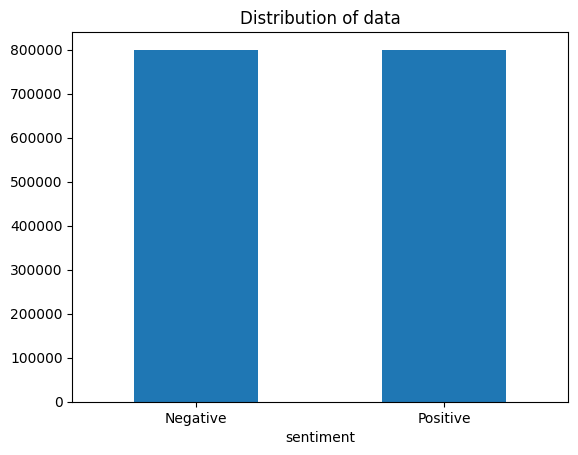

In [ ]:
 # utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for review in textdata:
        review = review.lower()
        review = re.sub(urlPattern,' URL',review)
        # Replace all emojis.
        for emoji in emojis.keys():
            review = review.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace @USERNAME to 'USER'.
        review = re.sub(userPattern,' USER', review)
        # Replace all non alphabets.
        review = re.sub(alphaPattern, " ", review)
        # Replace 3 or more consecutive letters by 2 letter.
        review = re.sub(sequencePattern, seqReplacePattern, review)
        reviewwords = ''
        for word in review.split():
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                reviewwords += (word+' ')

        processedText.append(reviewwords)

    return processedText
import time
t = time.time()
text = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')


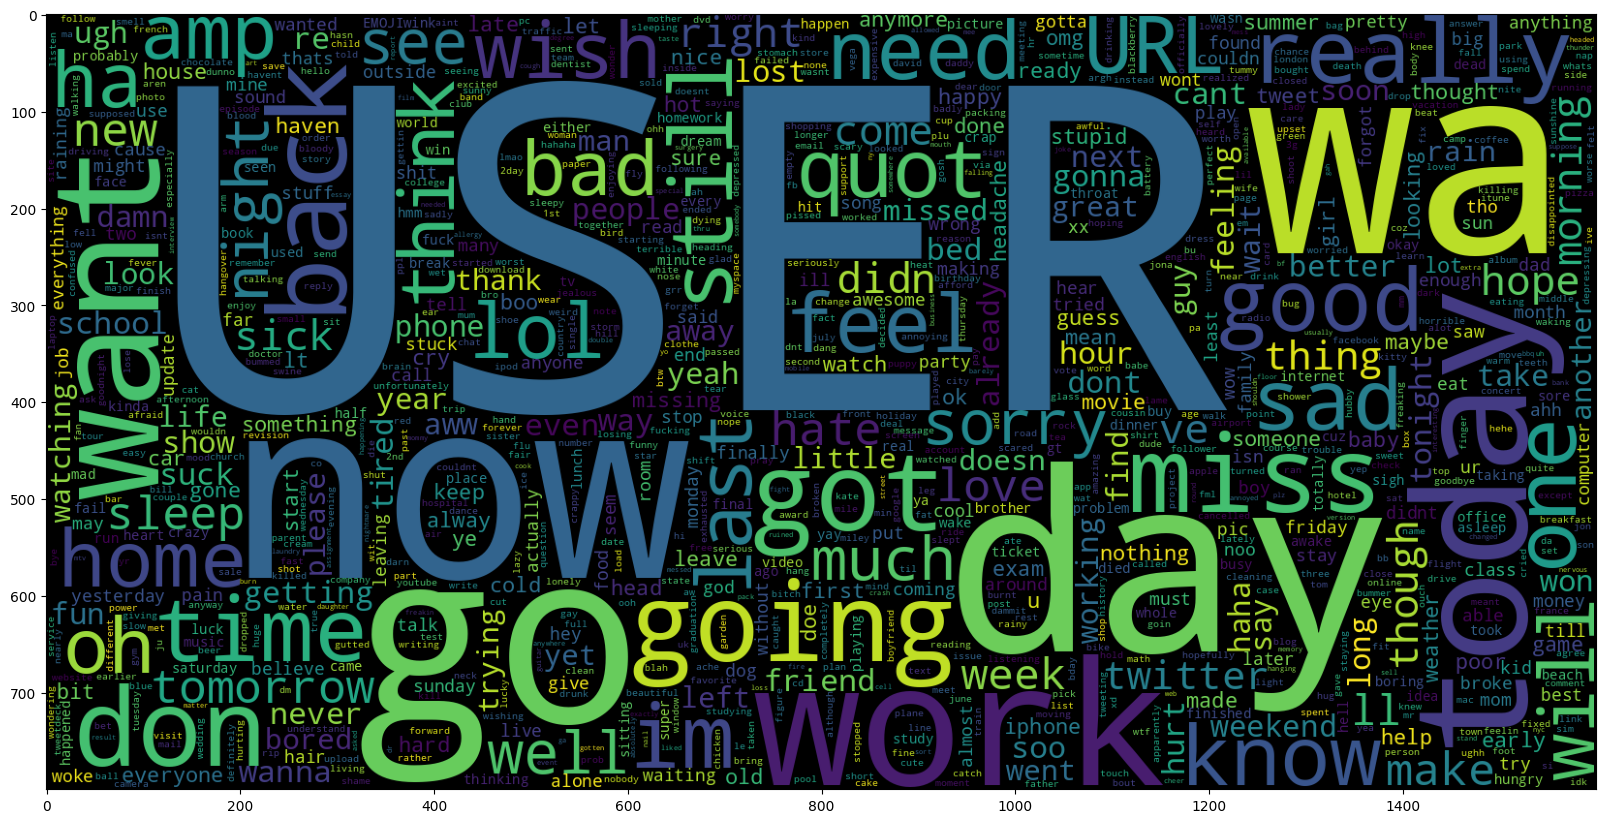

In [ ]:
data_neg = text[:800000]#negative sentiments
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)


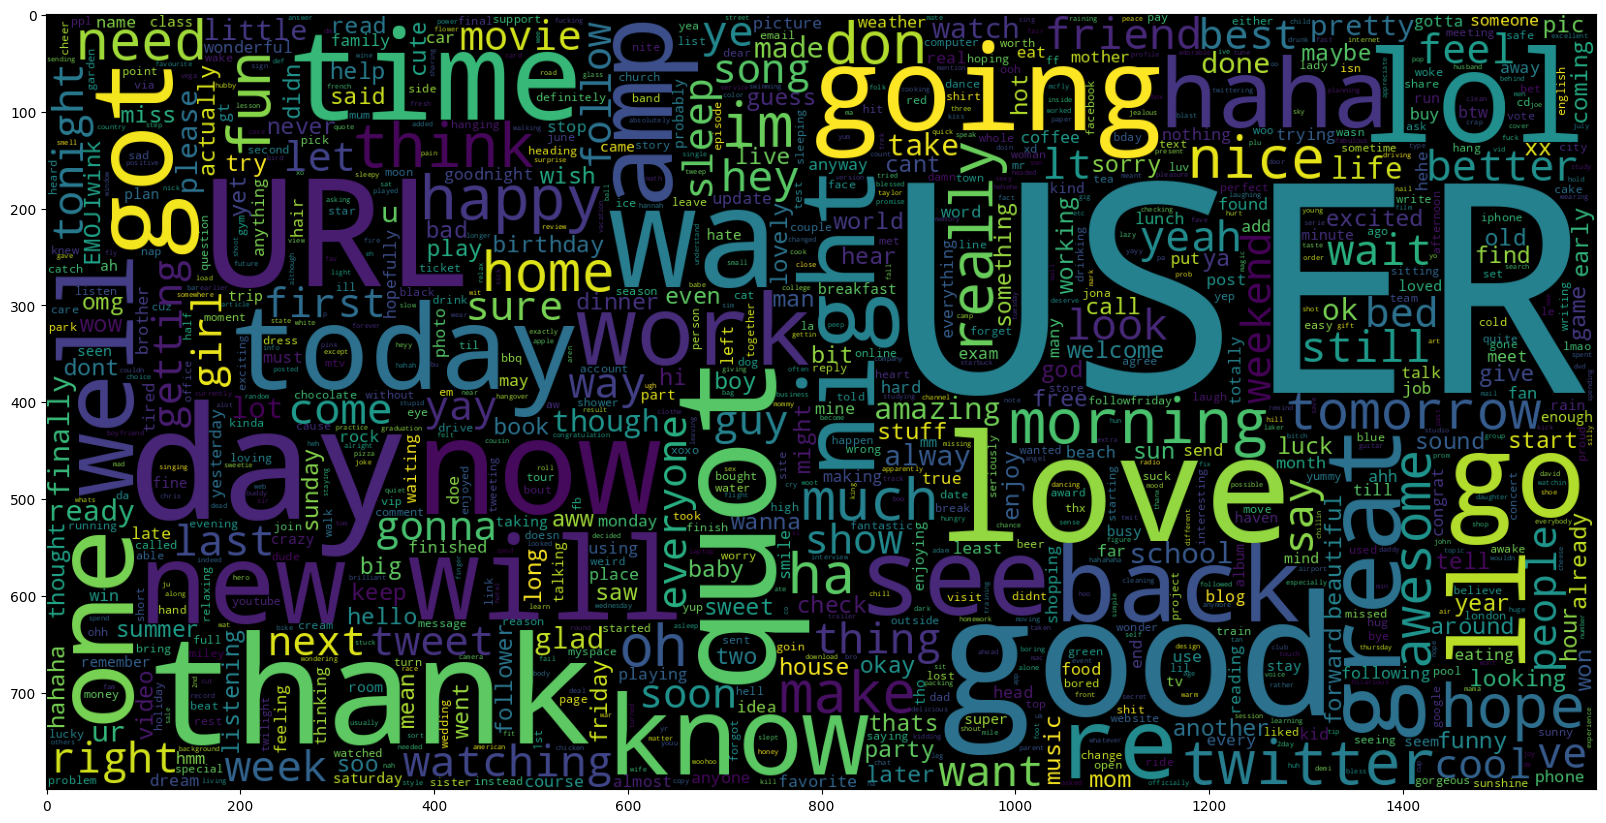

In [ ]:
data_pos =text[800000:]#positive sentiments
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  500000


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [ ]:
del zip
from sklearn.metrics import accuracy_score
from builtins import zip
def model_Evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    # Calculate accuracy and print it
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy*1.13)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = []
    for v1, v2 in zip(group_names, group_percentages):
      labels.append(f'{v1}\n{v2}')
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted values", fontdict={'size':14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size':14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size':18}, pad=20)


              precision    recall  f1-score   support

           0       0.81      0.76      0.78     39989
           1       0.78      0.82      0.80     40011

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000

Accuracy: 0.8923751249999999


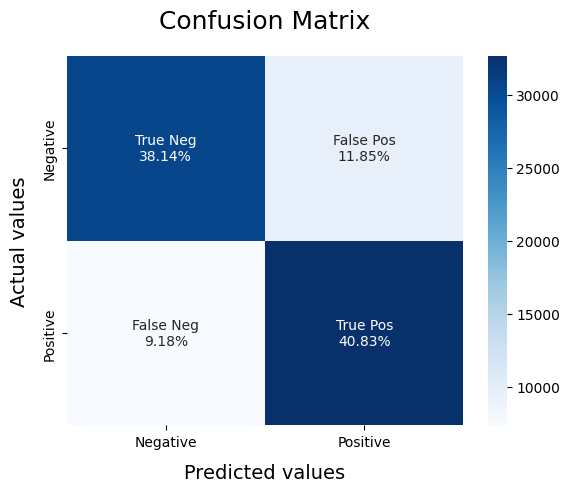

In [ ]:
BNBmodel = BernoulliNB(alpha = 50)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

## HyperParamter tuning of svm

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000

Accuracy: 0.9248485


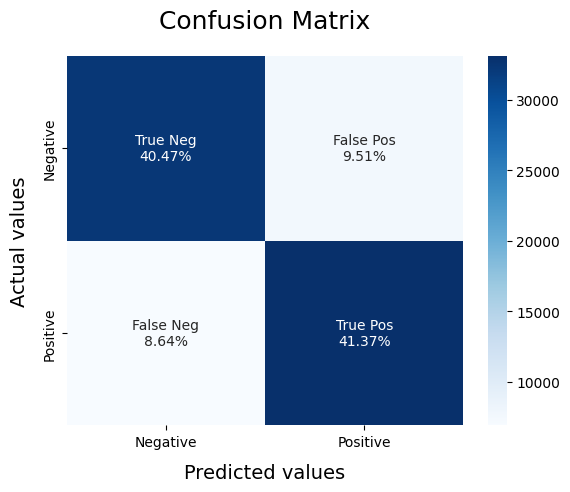

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)


In [ ]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('sentiment-SVC.pickle','wb')
pickle.dump(SVCmodel,file)

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [ ]:
def load_models():
    # Load the vectoriser.
    file = open('/content/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('/content/Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()

    file = open('/content/sentiment-SVC.pickle', 'rb')
    SVCmodel = pickle.load(file)
    file.close()

    return vectoriser, LRmodel, SVCmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)

    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))

    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    vectoriser, LRmodel ,SVCmodel = load_models()

    # Text to classify should be in a list.
    text = ["This has just been a long and rambling series of telling us to use technology because it's important to ensure the kids can cope with the digital age and to caution us that while doing so, we should meet the needs of learners and to align with learning objectives rather than use it based on personal whim and fancy. Other than flipped classroom (which is passe already), where are the pedagogical approaches that will actually help with learning? Instead we get very non-specific advice like ""you have to plan ahead and think about how to make the tool align"". I get that there are so many subjects that it's hard to find accessible case studies on specific subjects for a general teaching audience, but it really is very silly and poor to give us examples like using flikr to enhance one's photography class. On the SAMR evaluative model (which this course ought to talk about but does not), this is clearly at the lowest level!",
            "I was so motivated to attend this course ,pretty nice course and informative course yeah",
            "Very good course the only problem is that they take a long time to correct the HOME WORK",
            "There is a wealth of knowledge in this course. The creators put a lot of time and resources into making the course relatable to teachers. However, I do not recommend this course for early childhood teachers. I found the videos from other teachers within the modules unrelatable. While there is acknowledgement of the early childhood grades, I found that the course relates more to high school and university level teaching.",
            "I encountered many broken links and missing web pages in the readings.","not updated to match latest, Grading system is terrible."]
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                                                text sentiment
0  This has just been a long and rambling series ...  Negative
1  I was so motivated to attend this course ,pret...  Positive
2  Very good course the only problem is that they...  Negative
3  There is a wealth of knowledge in this course....  Positive
4  I encountered many broken links and missing we...  Negative
